In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import h5py
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

In [4]:
import shutil

In [5]:
import os
import glob

In [6]:
import bilby

09:46 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
09:46 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
09:46 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
09:46 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
09:46 bilby WARNING : You do not have gwpy installed currently. You will  not be able to use some of the prebuilt functions.
09:46 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.
09:46 bilby WARNING : You do not have lalsuite installed currently. You will not be able to use some of the prebuilt functions.


In [7]:
import numpy as np

In [8]:
from positive.physics import cw181003550
%matplotlib inline
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

(positive)>> Applying custom matplotlib settings.


# try their ansatz

In [9]:
import phenom
def get_remnant(eta, ell, mm):
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    final_mass = 1.0 - phenom.EradRational0815(eta, 0, 0)
    
    complex_rd = cw181003550(fin_spin, ell, mm, 0)
    omega_rd = np.real(complex_rd) / final_mass
    tdamp_rd = np.imag(complex_rd) / final_mass
    
    return omega_rd, 1./tdamp_rd

In [10]:
get_remnant(0.25, 2,2 )

(0.5536032718540641, 11.714214689922516)

In [11]:
get_remnant(0.25, 3,2 )

(0.7920216865553246, 11.234815148508739)

In [12]:
# https://arxiv.org/pdf/1212.5553.pdf eq. 3

In [13]:
def ep(t, ep0, di):
    return ep0 * np.exp(di * t)

In [14]:
def Ft_func(t, ep0, delta, dr, di):
    epsilon = ep(t, ep0, di)
    return 1 + 2*epsilon*np.cos(dr*t + delta) + epsilon**2

In [15]:
def kom32(t, ep0, delta, om32, om22, tau32, tau22):
    dr = om32 - om22
    di = (1./tau32) - (1./tau22)
    
    epsilon = ep(t, ep0, di)
    Ft = Ft_func(t, ep0, delta, dr, di)
    
    t1 = om32
    t2 = epsilon**2 * dr / Ft
    t3 = epsilon * (dr*np.cos(dr*t + delta) + di*np.sin(dr*t + delta)) / Ft
    
    return t1 - t2 - t3

In [16]:
eta = phenom.eta_from_q(1)
om22, tau22 = get_remnant(eta, 2, 2)
om32, tau32 = get_remnant(eta, 3, 2)

In [17]:
times = np.linspace(-50, 50, 1000)

In [18]:
ep0_22 = 3.2
ep0_32 = 0.2
delta = 0

In [19]:
y_22 = kom32(times, ep0_22, delta, om32, om22, tau32, tau22)
y_32 = kom32(times, ep0_32, delta, om32, om22, tau32, tau22)

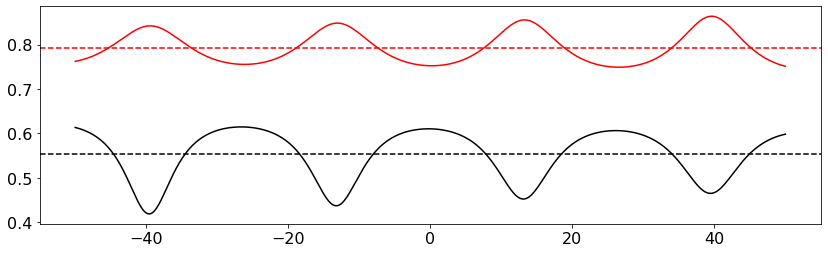

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(times, y_22, c='k')
plt.plot(times, y_32, c='r')
plt.axhline(om22, c='k',ls='--')
plt.axhline(om32, c='r',ls='--')
# plt.axhline(om22 + om32, c='b', ls='--')
# plt.axhline(om32 - om22, c='b', ls='-.')

# try fitting NR frequency data

In [21]:
def compute_integral(times, x, npts=None):
    """
    times = array of independent variable
    x = array of dependent variable
    npts = None (default to len(times)) number o fpoints to resample to integrate
    """
    
    if npts is None:
        npts = len(times)*2

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, 1000)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)

In [22]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [23]:
def planck_taper(times, t1, t2):
    """times: array of times
    t1. for t<=t1 then return 0
    t2. for t>=t2 then return 1
    else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
    tout = []
    for t in times:
        if t<=t1:
            tout.append(0.)
        elif t>=t2:
            tout.append(1.)
        else:
            tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
    return np.array(tout)

In [24]:
# Newton gravity constant
# lal.G_SI: 6.67384e-11
G_Newt = 6.67384e-11

In [25]:
# light speed
# lal.C_SI: 299792458.0
c_ls = 299792458.0

In [26]:
# lal.MSUN_SI: 1.9885469549614615e+30
MSUN_SI = 1.9885469549614615e+30

In [27]:
MTSUN_SI = 4.925491025543576e-06

In [28]:
# lal.MRSUN_SI: 1476.6250614046494
MRSUN_SI = 1476.6250614046494

In [29]:
# lal.PC_SI: 3.085677581491367e+16
PC_SI = 3.085677581491367e+16

In [30]:
# lal.GAMMA: 0.5772156649015329
GAMMA = 0.5772156649015329

In [31]:
def Msun_to_sec(M):
    """
    convert mass (in units of solar masses)
    into seconds
    """
#     return M *lal.MSUN_SI* G_Newt / c_ls**3.
    return M * MTSUN_SI

In [32]:
def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in Mpc
    M*G/c^2 * M_sun / dist
    """
    return mtot * MRSUN_SI / (distance * 1e6*PC_SI)

In [33]:
def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [34]:
class MultiModeNRWaveform(object):
    def __init__(self, nrfile, ell_mm_list, npts, t1=-600, t2=60):
        """
        ell_mm_list e.g. [(2,2), (3,2)]
        """

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2
        self.ell_mm_list = ell_mm_list

        self.times = np.linspace(self.t1, self.t2, self.npts)
        
        self.get_lm_modes(self.nrfile, self.ell_mm_list, self.npts)


    def get_lm_modes(self, nrfile, ell_mm_list, npts):
        
        self.hlms = {}
        
        for ell, mm in ell_mm_list:

            if 'SXS' in nrfile:
                f = h5py.File(nrfile, 'r')

                self.q = f.attrs['mass1']/f.attrs['mass2']
                self.eta = f.attrs['eta']

                amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
                amp_x = amp_tmp['X'][:]
                amp_y = amp_tmp['Y'][:]

                phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
                phase_x = phase_tmp['X'][:]
                phase_y = phase_tmp['Y'][:]

                f.close()
            elif 'Sur' in nrfile:
                f = h5py.File(nrfile, 'r')
                self.q = f.attrs['q']
                self.mtot = 1
                self.eta = phenom.eta_from_q(self.q)
                mass1, mass2 = phenom.utils.m1_m2_M_q(self.mtot, self.q)
                
                if (ell == 2) & (mm == 2):
                    times, re_hlm, im_hlm = f['data22'][:].T
                elif (ell == 3) & (mm == 2):
                    times, re_hlm, im_hlm = f['data32'][:].T
                
                # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
                hlm = re_hlm + 1.j * im_hlm

                amp_x = times
                amp_y = np.abs(hlm)

                phase_x = times
                phase_y = np.unwrap(np.angle(hlm))
                f.close()
                
                
            else:
                # bam
                self.sim_dir = os.path.dirname(nrfile)
                self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
                # strict=False because of DuplicateSectionError
                config = configparser.ConfigParser(strict=False)

                config.read(self.bbh_file)
                mass1_tmp = float(config['metadata']['mass1'])
                mass2_tmp = float(config['metadata']['mass2'])
                self.initial_sep = float(config['metadata']['initial-separation'])

                if mass1_tmp >= mass2_tmp:
                    mass1 = mass1_tmp
                    mass2 = mass2_tmp
                else:
                    mass1 = mass2_tmp
                    mass2 = mass1_tmp


                self.mass1 = mass1
                self.mass2 = mass2
                self.mtot = self.mass1 + self.mass2
                self.q = self.mass1 / self.mass2
                self.eta = self.mass1 * self.mass2 / (self.mtot)**2.

                times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

                # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
                hlm = re_hlm - 1.j * im_hlm

                amp_x = times
                amp_y = np.abs(hlm)

                phase_x = times
                phase_y = np.unwrap(np.angle(hlm))


            if (ell == 2) & (mm == 2):
                # shift so that amp peak is at t=0 - will need to be more careful with HMs
                amp_peak_idx_22 = amp_y.argmax()
                amp_peak_time_22 = amp_x[amp_peak_idx_22]
                amp_x = amp_x - amp_peak_time_22
                phase_x = phase_x - amp_peak_time_22
            else:
                amp_x = amp_x - amp_peak_time_22
                phase_x = phase_x - amp_peak_time_22


            amp_i = IUS(amp_x, amp_y)
            phase_i = IUS(phase_x, phase_y)          

            amplist = amp_i(self.times)
            
            # align phase s.t. at t=10 after peak of 22 stran the phase is zeri
#             phi_0 = phase_i(10)
#             phase_i = IUS(phase_x, phase_y - phi_0)
            phaselist = phase_i(self.times)
            
            freqlist = phase_i.derivative()(self.times)

            
            amp = amplist
            phi = phaselist
            freq = freqlist
            hlm = amp * np.exp(-1.j * phi)
            
            hlm_dict = {
                'times':self.times,
                'amp':amp,
                'phi':phi,
                'hlm':hlm,
                'freq':freq
            }
            
            self.hlms.update({(ell,mm):hlm_dict})
            
        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
        
        self.om22, self.tau22 = get_remnant(eta, 2, 2)
        self.om32, self.tau32 = get_remnant(eta, 3, 2)
        self.om22 = -self.om22
        self.om32 = -self.om32

    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)


In [35]:
# lets load a few resolutions of the same case to get uncertainty

In [36]:
# if you want to add surrogate data then set this
USE_SUR_DATA = True
sur_data_files = sorted(glob.glob('/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/*'))

In [37]:
sur_keys = [sur.split('/')[-1].split('.h5')[0].split('_')[-1].replace(".","p") for sur in sur_data_files]


In [38]:
sur_dict_files = {}
[sur_dict_files.update({sur_keys[i]:sur_data_files[i]}) for i in range(len(sur_keys))];

In [39]:
sur_dict_files

{'q1p0': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q1.0.h5',
 'q1p2': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q1.2.h5',
 'q1p4': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q1.4.h5',
 'q1p6': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q1.6.h5',
 'q1p8': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q1.8.h5',
 'q2p0': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q2.0.h5',
 'q2p2': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q2.2.h5',
 'q2p4': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q2.4.h5',
 'q2p6': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q2.6.h5',
 'q2p8': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q2.8.h5',
 'q3p0': '/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/NRSur3dq8_q3.0.h5',
 'q3p2': '/Users/spx8

In [40]:
nrfiles = dict(
        q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
        q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
        q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
        q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
        q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5'
    )





# nrfiles = dict(
#         q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
#         q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
#         q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
#         q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
#         q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
#         q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5",
#     )

# nrfiles = dict(
#     q10_3 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5',
#     q10_4 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
#     q10_5 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5'
# )


ell_mm_list = [(2,2),(3,2)]
# ell_mm_list = [(2,2)]
npts_time = 1000*4

t1=-600
t2=100

if USE_SUR_DATA:
    nrfiles.update(sur_dict_files)
    t1=-200


nrdatas = {}

for k in nrfiles.keys():
    nrfile = nrfiles[k]
    nrdatas.update({k:MultiModeNRWaveform(nrfile, ell_mm_list, npts_time, t1=t1,t2=t2)})

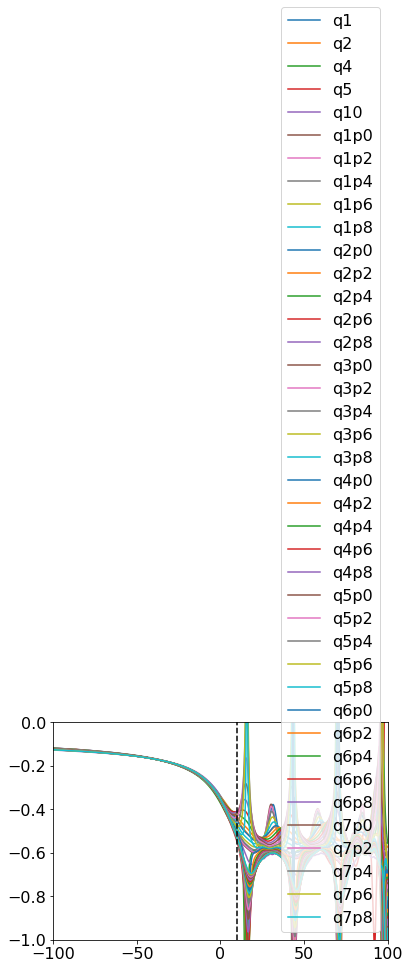

In [41]:
# mode = (2,2)
mode = (3,2)
plt.figure()

for k in nrdatas.keys():
    plt.plot(nrdatas[k].hlms[mode]['times'], nrdatas[k].hlms[mode]['freq'], label=k)
plt.xlim(-100,100)
plt.ylim(-1,0)
plt.legend()
plt.axvline(10, c='k', ls='--')

# fit using emcee via lmfit

In [42]:
import lmfit
import corner

In [43]:
def ansatz_latetime(t, ep0, delta, om32, om22, tau32, tau22):

#     ep0 = params['ep0']
#     delta = params['delta']
#     om32 = params['om32']
#     om22 = params['om22']
#     tau32 = params['tau32']
#     tau22 = params['tau22']

    dr = om32 - om22
    di = (1./tau32) - (1./tau22)

    epsilon = ep(t, ep0, di)
    Ft = Ft_func(t, ep0, delta, dr, di)

    t1 = om32
    t2 = epsilon**2 * dr / Ft
    t3 = epsilon * (dr*np.cos(dr*t + delta) + di*np.sin(dr*t + delta)) / Ft

    return t1 - t2 - t3

In [44]:
model_latetime = lmfit.Model(ansatz_latetime)

In [45]:
model_latetime.independent_vars

['t']

In [46]:
model_latetime.param_names

['ep0', 'delta', 'om32', 'om22', 'tau32', 'tau22']

In [47]:
model_latetime.set_param_hint('ep0', value=0.9, min=0, max=2)
model_latetime.set_param_hint('delta', value=0.3, min=0, max=2)
model_latetime.set_param_hint('om32', value=0.5)
model_latetime.set_param_hint('om22', value=1)
model_latetime.set_param_hint('tau32', value=2)
model_latetime.set_param_hint('tau22', value=1, vary=False)

In [48]:
pars=model_latetime.make_params()

In [49]:
pars

Parameters([('ep0', <Parameter 'ep0', value=0.9, bounds=[0:2]>),
            ('delta', <Parameter 'delta', value=0.3, bounds=[0:2]>),
            ('om32', <Parameter 'om32', value=0.5, bounds=[-inf:inf]>),
            ('om22', <Parameter 'om22', value=1, bounds=[-inf:inf]>),
            ('tau32', <Parameter 'tau32', value=2, bounds=[-inf:inf]>),
            ('tau22',
             <Parameter 'tau22', value=1 (fixed), bounds=[-inf:inf]>)])

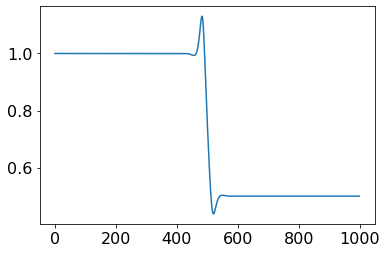

In [50]:
plt.plot(model_latetime.eval(t=np.linspace(-100,100,1000),**pars))

In [51]:
model_latetime.param_hints

OrderedDict([('ep0', OrderedDict([('value', 0.9), ('min', 0), ('max', 2)])),
             ('delta', OrderedDict([('value', 0.3), ('min', 0), ('max', 2)])),
             ('om32', OrderedDict([('value', 0.5)])),
             ('om22', OrderedDict([('value', 1)])),
             ('tau32', OrderedDict([('value', 2)])),
             ('tau22', OrderedDict([('value', 1), ('vary', False)]))])

In [52]:
# data to fit
k = 'q4p2'
mode = (3,2)
t1 = 20
t2 = 80
x = nrdatas[k].hlms[mode]['times']
y = nrdatas[k].hlms[mode]['freq']

mask = (x>=t1) & (x<=t2)
x = x[mask]
y = y[mask]

om22 = nrdatas[k].om22
om32 = nrdatas[k].om32
tau22 = nrdatas[k].tau22
tau32 = nrdatas[k].tau32
    
ep0 = 2.1
d0 = 0.8

model_latetime = lmfit.Model(ansatz_latetime)

model_latetime.set_param_hint('ep0', value=0.1, min=-1, max=3)
model_latetime.set_param_hint('delta', value=0.3, min=-10, max=10)
model_latetime.set_param_hint('om32', value=om32, vary=False)
model_latetime.set_param_hint('om22', value=om22, vary=False)
model_latetime.set_param_hint('tau32', value=tau32, vary=False)
model_latetime.set_param_hint('tau22', value=tau22, vary=False)

p = model_latetime.make_params()

In [53]:
result = model_latetime.fit(data=y, t=x, params=p, method='Nelder')

/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/lmfit/minimizer.py:786: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/Users/spx8sk/anaconda3/envs/wispy-dev/lib/python3.7/site-packages/lmfit/minimizer.py:779: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


In [54]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 88
    # data points      = 800
    # variables        = 2
    chi-square         = 3.66265097
    reduced chi-square = 0.00458979
    Akaike info crit   = -4305.13963
    Bayesian info crit = -4295.77040
##  Warning: uncertainties could not be estimated:
[[Variables]]
    ep0:    0.74133404 +/- 0.00411152 (0.55%) (init = 0.1)
    delta:  0.72599336 +/-        nan (nan%) (init = 0.3)
    om32:  -0.697751 (fixed)
    om22:  -0.4632762 (fixed)
    tau32:  10.89708 (fixed)
    tau22:  11.34318 (fixed)


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

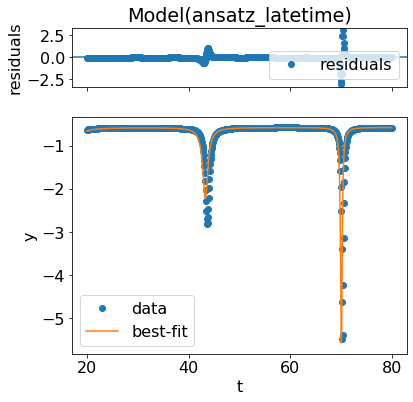

In [55]:
result.plot()

In [56]:
emcee_kws = dict(steps=1000, burn=300, thin=20, is_weighted=False,
                 progress=True, workers=1, nwalkers=200)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [57]:
result_emcee = model_latetime.fit(data=y, t=x, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

100%|██████████| 1000/1000 [00:27<00:00, 36.40it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.53413835 45.49103492 71.08829761]


In [58]:
lmfit.report_fit(result_emcee)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 200000
    # data points      = 800
    # variables        = 3
    chi-square         = 795.838717
    reduced chi-square = 0.99854293
    Akaike info crit   = 1.82785672
    Bayesian info crit = 15.8816919
[[Variables]]
    ep0:        0.74131182 +/- 3.0257e-04 (0.04%) (init = 0.741334)
    delta:      0.78134703 +/- 4.2622e-04 (0.05%) (init = 0.7259934)
    om32:      -0.697751 (fixed)
    om22:      -0.4632762 (fixed)
    tau32:      10.89708 (fixed)
    tau22:      11.34318 (fixed)
    __lnsigma: -2.69060672 +/- 0.02570492 (0.96%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(ep0, delta)       =  0.999
    C(delta, __lnsigma) = -0.976
    C(ep0, __lnsigma)   = -0.976


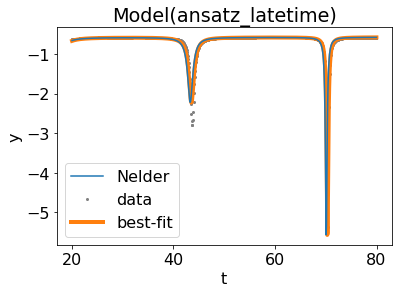

In [59]:
ax = plt.plot(x, model_latetime.eval(params=result.params, t=x), label='Nelder', zorder=100)
result_emcee.plot_fit(ax=ax, data_kws=dict(color='gray', markersize=2), fit_kws=dict(lw=4))
plt.show()

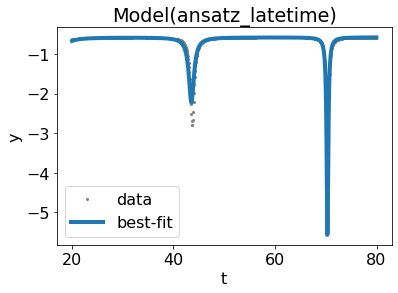

In [66]:
result_emcee.plot_fit(ax=ax, data_kws=dict(color='gray', markersize=2), fit_kws=dict(lw=4))
# plt.ylim(-1,1)
plt.show()

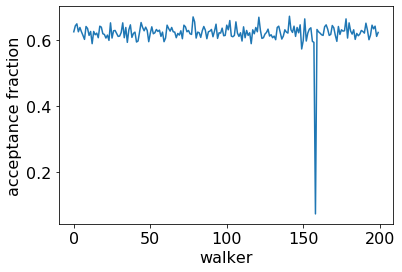

In [67]:
plt.plot(result_emcee.sampler.acceptance_fraction)
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

In [62]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result.params):
        print(p, result.acor[i])

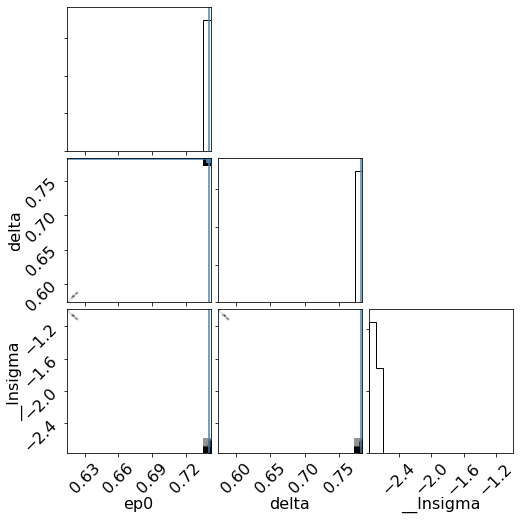

In [63]:
emcee_corner = corner.corner(result_emcee.flatchain, labels=result_emcee.var_names,
                             truths=list(result_emcee.params.valuesdict().values()))

In [68]:
emcee_params

Parameters([('ep0',
             <Parameter 'ep0', value=0.74133403672896 +/- 0.00411, bounds=[-1:3]>),
            ('delta',
             <Parameter 'delta', value=0.7259933587666794 +/- nan, bounds=[-10:10]>),
            ('om32',
             <Parameter 'om32', value=-0.6977509922948906 (fixed), bounds=[-inf:inf]>),
            ('om22',
             <Parameter 'om22', value=-0.46327622695621307 (fixed), bounds=[-inf:inf]>),
            ('tau32',
             <Parameter 'tau32', value=10.897081846454936 (fixed), bounds=[-inf:inf]>),
            ('tau22',
             <Parameter 'tau22', value=11.34317671654508 (fixed), bounds=[-inf:inf]>),
            ('__lnsigma',
             <Parameter '__lnsigma', value=-2.3025850929940455, bounds=[-6.907755278982137:0.6931471805599453]>)])

In [65]:
print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(result_emcee.params)

# find the maximum likelihood solution
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]

print("\nMaximum likelihood Estimation")
print('-----------------------------')
for ix, param in enumerate(result_emcee.var_names):
    print(param + ': ' + str(mle_soln[ix]))

quantiles = np.percentile(result_emcee.flatchain['ep0'], [2.28, 15.9, 50, 84.2, 97.7])
print("\n\n1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))


median of posterior probability distribution
--------------------------------------------
[[Variables]]
    ep0:        0.74131182 +/- 3.0257e-04 (0.04%) (init = 0.741334)
    delta:      0.78134703 +/- 4.2622e-04 (0.05%) (init = 0.7259934)
    om32:      -0.697751 (fixed)
    om22:      -0.4632762 (fixed)
    tau32:      10.89708 (fixed)
    tau22:      11.34318 (fixed)
    __lnsigma: -2.69060672 +/- 0.02570492 (0.96%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(ep0, delta)       =  0.999
    C(delta, __lnsigma) = -0.976
    C(ep0, __lnsigma)   = -0.976

Maximum likelihood Estimation
-----------------------------
ep0: 0.7413395968614092
delta: 0.7813611676681277
__lnsigma: -2.6931675011846203


1 sigma spread 0.0003026396963413114
2 sigma spread 0.0006229234291603158
